### Doccano Annotation

Commands to run doccano locally:

```
docker pull chakkiworks/doccano
docker run -d --name doccano -p 8000:8000 chakkiworks/doccano
# docker run -d --rm --name doccano -p 8000:8000 chakkiworks/doccano # To delete on stop
docker exec doccano tools/create-admin.sh "admin" "admin@example.com" "password"
```

In [3]:
import os
import os.path as osp
import pandas as pd
import numpy as np
import snorkel
from snorkel.models import Candidate
from snorkel import SnorkelSession
from tcre.env import *
from tcre import supervision

In [4]:
session = SnorkelSession()
classes = supervision.get_candidate_classes()

In [ ]:
# Sentence ids with great candidates:
# - 700024, 711845, 704300, 519494, 777986

In [20]:
# Pull list of all non-annotated candidate ids and types
dfc = pd.DataFrame(
    session.query(Candidate.id, Candidate.type).filter(Candidate.split == supervision.SPLIT_INFER).all(),
    columns=['id', 'type']
)
# Because inducing and secreted cytokine relations have the same candidates, only one type needs to be used
dfc = dfc[dfc['type'] != classes.secreted_cytokine.field]
dfc.groupby('type').size()

type
inducing_cytokine                90915
inducing_transcription_factor    35933
dtype: int64

In [21]:
dfc.head()

,id,type
0,1,inducing_cytokine
1,2,inducing_cytokine
2,3,inducing_cytokine
3,4,inducing_cytokine
4,5,inducing_cytokine


In [22]:
# Generate samples for each type
dfs = dfc.groupby('type', group_keys=False).apply(lambda g: g.sample(n=500, random_state=TCRE_SEED))
dfs.groupby('type').size()

type
inducing_cytokine                500
inducing_transcription_factor    500
dtype: int64

In [23]:
# Convert to JSONL files for docanno; Example:
# {"text": "EU rejects German call to boycott British lamb.", "labels": [ [0, 2, "ORG"], [11, 17, "MISC"], ... ]}
# {"text": "Peter Blackburn", "labels": [ [0, 15, "PERSON"] ]}
# {"text": "President Obama", "labels": [ [10, 15, "PERSON"] ]}

markers = {
    supervision.ENT_TYP_CK_L: '||',
    supervision.ENT_TYP_CT_L: '$$',
    supervision.ENT_TYP_TF_L: '@@',
}

def process(r):
    cand = session.query(Candidate).filter(Candidate.id == r['id']).one()
    sent = cand.get_parent()
    doc = sent.get_parent()
    words = list(cand.get_parent().words)
    ctxs = cand.get_contexts()
    
    for ctx in ctxs:
        rng = ctx.get_word_range()
        typ = cand.get_parent().entity_types[rng[0]]
        # Add visual markers in the text to make the entities in question clear
        words[rng[0]] = markers[typ] + words[rng[0]]
        words[rng[1]] = words[rng[1]] + markers[typ] 
    meta = dict(
        type=cand.type, doc_id=doc.name, 
        # Add sentence id, absoluate character offset of first character, index of sentence in document, and sent length (in words)
        sent_id=sent.id, sent_abs_offset=sent.abs_char_offsets[0], sent_pos=sent.position, sent_len=len(sent.words),
        # Add text and start/end (INCLUSIVE) char span for each entity
        e1_text=ctxs[0].get_span(), e1_start_chr=ctxs[0].char_start, e1_end_chr=ctxs[0].char_end,
        e2_text=ctxs[1].get_span(), e2_start_chr=ctxs[1].char_start, e2_end_chr=ctxs[1].char_end
    )
    return dict(text=' '.join(words), labels=[], meta=meta)

dfexp = pd.DataFrame(list(dfs.apply(process, axis=1).values))
dfexp.head()

,labels,meta,text
0,[],"{'type': 'inducing_cytokine', 'doc_id': 'PMC42...","Recently , many studies reported that miR-21 i..."
1,[],"{'type': 'inducing_cytokine', 'doc_id': 'PMC58...",The chief mechanisms by which Tr1 cells contro...
2,[],"{'type': 'inducing_cytokine', 'doc_id': 'PMC56...","a , b Naive T cells were differentiated into T..."
3,[],"{'type': 'inducing_cytokine', 'doc_id': 'PMC42...",Detection of cytokines from RA patients reveal...
4,[],"{'type': 'inducing_cytokine', 'doc_id': 'PMC59...","However , GATA3 is no longer required for ||IL..."


In [24]:
dfexp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
labels    1000 non-null object
meta      1000 non-null object
text      1000 non-null object
dtypes: object(3)
memory usage: 23.5+ KB


In [25]:
dfexp.apply(lambda r: r['meta']['type'], axis=1).value_counts()

inducing_transcription_factor    500
inducing_cytokine                500
dtype: int64

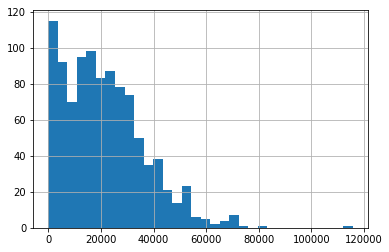

In [15]:
%matplotlib inline
dfexp.apply(lambda r: r['meta']['sent_abs_offset'], axis=1).hist(bins=32)

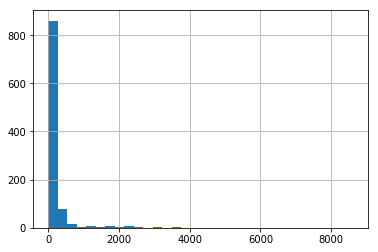

In [16]:
%matplotlib inline
dfexp.apply(lambda r: r['meta']['e1_start_chr'], axis=1).hist(bins=32)

In [17]:
path = osp.join(REPO_DATA_DIR, 'doccano', 'annotations_import.jsonl')
dfexp.to_json(path, orient='records', lines=True)
path

'/lab/repos/t-cell-relation-extraction/data/doccano/annotations_import.jsonl'

### Reload and Export

Doccano only exports the internal id for labels, so to get the associated string label use:

```bash
docker exec -i doccano /bin/bash - << EOF
python -c '
import sqlite3
conn = sqlite3.connect("app/db.sqlite3")
# Must replace project_id here (e.g. from url in web app)
rows = conn.execute("SELECT id, text FROM api_label WHERE project_id = 1;").fetchall()
print("\n".join([",".join(map(str, r)) for r in rows]))
'
EOF
```

See: https://github.com/chakki-works/doccano/issues/295

In [1]:
# These labels need to be defined on a fresh run of the doccano container
# and they need to be defined in an order that corresponds with the dict below
# (for some reason, doccano only exports the internal id associated with the label,
# which will increment indefinitely as you add projects and label categories)
labels = {
    1: ('inducing_cytokine', 1), 
    2: ('inducing_cytokine', -1), 
    3: ('secreted_cytokine', 1),
    4: ('secreted_cytokine', -1), 
    5: ('inducing_transcription_factor', 1), 
    6: ('inducing_transcription_factor', -1) 
}

In [5]:
# Read doccano export:
# {"id": 1, "text": "EU rejec...", "annotations": [{"label": 2, "user": 1}, "label": 1, "user": 1}], "meta": {"s2": "yes", "s1": 1}, "annotation_approver": null}
# {"id": 2, "text": "Peter Bl...", "annotations": [{"label": 2, "user": 1}], "meta": {"s2": "yes", "s1": 1}, "annotation_approver": null}
# {"id": 3, "text": "Presiden...", "annotations": [{"label": 1, "user": 1}], "meta": {"s2": "yes", "s1": 1}, "annotation_approver": null}

path = osp.join(REPO_DATA_DIR, 'doccano', 'annotations_export.jsonl')
df = pd.read_json(path, lines=True)
df = pd.DataFrame([
    {**r['meta'], **dict(type=labels[a['label']][0], value=labels[a['label']][1])}
    for i, r in df.iterrows()
    for a in r['annotations']
])
df.head()

,doc_id,e1_end_chr,e1_start_chr,e1_text,e2_end_chr,e2_start_chr,e2_text,sent_abs_offset,sent_id,sent_len,sent_pos,type,value
0,PMC4224555,238,234,IL-12,208,206,Th2,3937,510800,70,24,secreted_cytokine,-1
1,PMC4224555,238,234,IL-12,208,206,Th2,3937,510800,70,24,inducing_cytokine,-1
2,PMC5818395,138,136,Tr1,348,339,effector T,422,516679,61,3,secreted_cytokine,-1
3,PMC5818395,138,136,Tr1,348,339,effector T,422,516679,61,3,inducing_cytokine,-1
4,PMC5634439,325,321,IL-23,55,52,Th17,18552,765061,88,154,secreted_cytokine,-1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 13 columns):
doc_id             1500 non-null object
e1_end_chr         1500 non-null int64
e1_start_chr       1500 non-null int64
e1_text            1500 non-null object
e2_end_chr         1500 non-null int64
e2_start_chr       1500 non-null int64
e2_text            1500 non-null object
sent_abs_offset    1500 non-null int64
sent_id            1500 non-null int64
sent_len           1500 non-null int64
sent_pos           1500 non-null int64
type               1500 non-null object
value              1500 non-null int64
dtypes: int64(9), object(4)
memory usage: 152.4+ KB


In [7]:
df['type'].value_counts()

inducing_transcription_factor    500
inducing_cytokine                500
secreted_cytokine                500
Name: type, dtype: int64

In [8]:
df.groupby(['type', 'value']).size()

type                           value
inducing_cytokine              -1       472
                                1        28
inducing_transcription_factor  -1       400
                                1       100
secreted_cytokine              -1       420
                                1        80
dtype: int64

In [9]:
path = osp.join(REPO_DATA_DIR, 'annotation', 'doccano_export.csv')
df.to_csv(path, index=False)
path

'/lab/repos/t-cell-relation-extraction/data/annotation/doccano_export.csv'